# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico II : Análisis de features de audio

Algunas aclaraciones:
- En 2) todos los pasos deberían poder hacerse en una línea, aunque si se complican y necesitan hacerlo en más no hay problema
- En 3) les dejé un buen spoiler para que lo completen
- Todas los conceptos y librerias que vamos a usar están documentados en el notebook
- Esta vez vamos a ser más rígidos con los plazos, la entrega es el 05/08, la única instancia previa de corrección son las entregas ANTES de la fecha mencionada, caso contrario es la nota final.

### Librerías

!pip3 install spotipy
!pip3 install pandas
!pip3 install spacy
!pip3 install pymusixmatch
!pip3 install nltk

# Agregar las librerías extra que se utilicen en esta celda y la siguiente

### Dependencias y acceso al API

In [107]:
import pandas as pd
import numpy as np
import spotipy
import spacy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import json
import seaborn as sns
import tqdm

client_id = '46b333d567314a89a6254b6c6b054be6'
client_secret = '9d922c3613e441518349dcf55f7d5853'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

nlp = spacy.load("en_core_web_sm") #completar con el modelo que van a utilizar

sns.set_context(context='paper')

In [108]:
# aux methods

def song_url_for_request(artist, song_title):
    return "https://api.lyrics.ovh/v1/" + artist + '/' + song_title #str
    #example use
    #requests.get(song_url_for_request("Death Grips", "Hacker"))
    

def songs_from_album_id(album_id):
    songs = []
    album = sp.album(album_id)
    artist = album['artists'][0]['name']
    for item in album['tracks']['items']:
        track = {}
        track["song_name"] = item['name']
        track["lyrics"]=[]
        track["song_id"] = item['id']
        track["album_name"] = album['name']
        track["album_id"] = album["id"]
        track["artist"] = artist
        songs.append(track)
    return songs    #songs:List[dict]



def genres_by_artist_id(id): #id: str
    artist = sp.artist(id)
    genres = artist['genres']
    return genres    #genres: List[str]

In [140]:
genres_by_artist_id("5K4W6rqBFWDnAN6FQUkS6x")

['chicago rap', 'rap']

## Question:
- How has Kanye West's vocabulary evolved through time?

### From this question we can derive:
- Are there many differences from album to album?
- Can we differentiate epochs in Kanye West's career by analysing his songs' vocabulary?

### 2) Obtener datos para responder la pregunta
Una vez obtenidas las letras de las canciones, las procesaremos de la siguiente manera:
1. Tokenizar
2. Remover las [stop-words](https://es.wikipedia.org/wiki/Palabra_vac%C3%ADa)
3. [Lema](https://es.wikipedia.org/wiki/Lema_(ling%C3%BC%C3%ADstica))tizar las palabras que hayan quedado
4. Organizar todo en un DataFrame de la forma Canción-Artista-Letra donde Letra es el resultado de 3.

**Recomendación** : Usar un dataframe para su artista y otro para la competencia si es que eligierone esa opción, les va a ahorrar tiempo.

**Aclaración** : Si plantearon una pregunta que no requiera los datos de la consigna, obtengan esos datos.

First we build Death Grip's dataset. We'll be using lyrics from 5 albums;

- No Love Deep Web
- The money store
- The powers that B
- Bottomless Pit
- Year of the snitch

for a total of 151 songs. After sanitization, 133.

In [110]:
death_grips=["08aqY8lv4zx4uaqBUpMD8a", 
              "1PQDjdBpHPikAodJqjzm6a",
              "5Y04ylQjDWsawOUJXzY4YO",
              "4dIPUQHheyH9e6ioplvNT2", 
              "46eayJPxf1cBWWUqNa2MJJ",
            "3T01oOjbrox1jz0pR112oV"]
bjork = ["2Fb37JsRMVPASJcl3wwDOa",
                "3p7WXDBxhC5KS9IFXnwae7", 
              "3knDOJUQBAATXsKYLWO4k8",
               "4u3MPfHM60rFFULJebZIay",
               "5GV4CBWPqU7P05KUaKyDZ1",
               "7FNtMOO3btvce2G5paXtsE",
               "2i0mqPNTcaLcmKWSMsE3c8",
               "64EKrS1Ubw2rQ9qn9QRUq3"]
kanye_west=["0FgZKfoU2Br5sHOfvZKTI9",
           "6pwuKxMUkNg673KETsXPUV",
           "2Ek1q2haOnxVqhvVKqMvJe",
           "7gsWAHLeT0w7es6FofOXk1",
           "7D2NdGvBHIavgLhmcwhluK",
           "2P2Xwvh2xWXIZ1OWY9S9o5",
           "20r762YmB5HeofjMCiPMLv",
           "5fPglEDz9YEwRgbLRvhCZy",
           "3WFTGIO6E3Xh4paEOBY9OU",
           "5ll74bqtkcXlKE7wwkMq4g",
           "4Uv86qWpGTxf7fU7lG5X6F"]

In [111]:
DG_ALBUM_IDS = kanye_west


def lemmafy(doc):
    lemmas = []
    for token in doc:
        if not token.is_stop and token.is_alpha:
             lemmas.append(token.lemma_)
    return lemmas

In [112]:
#arm base dataset
def build_from_album_ids(album_id_array):
    all_songs = []
    for album in tqdm.tqdm(album_id_array):
        all_songs += songs_from_album_id(album)
    return all_songs
    
dg_all_songs = build_from_album_ids(DG_ALBUM_IDS)

100%|██████████| 11/11 [00:03<00:00,  3.33it/s]


In [131]:
#put song lyrics in dataset
def add_lyrics_to_data(all_songs):
    for song in tqdm.tqdm(all_songs):
        response = requests.get(song_url_for_request(song["artist"],song["song_name"]))
        json_data = json.loads(response.content)
        try:
            lyrics_raw = json_data["lyrics"]
            doc = nlp(lyrics_raw)
            lemmed = lemmafy(doc)
            song["lyrics"]=[word.lower() for word in lemmed]
        except: #found a song without lyrics!
            print(song["song_name"])
            song["lyrics"]=None
    return all_songs

dg_all_songs = add_lyrics_to_data(dg_all_songs)


  1%|          | 1/151 [00:01<03:29,  1.40s/it]

Every Hour


  4%|▍         | 6/151 [00:07<03:16,  1.35s/it]

Everything We Need


  7%|▋         | 10/151 [00:13<03:10,  1.35s/it]

Use This Gospel


 10%|▉         | 15/151 [00:19<02:55,  1.29s/it]

Freeee (Ghost Town Pt. 2)


 37%|███▋      | 56/151 [01:14<02:10,  1.38s/it]

No Church In The Wild


 38%|███▊      | 58/151 [01:16<02:08,  1.38s/it]

Ni**as In Paris


 40%|███▉      | 60/151 [01:19<02:03,  1.36s/it]

Gotta Have It


 41%|████      | 62/151 [01:22<01:59,  1.35s/it]

That's My Bitch


 42%|████▏     | 63/151 [01:23<01:57,  1.34s/it]

Welcome To The Jungle


 42%|████▏     | 64/151 [01:24<01:54,  1.32s/it]

Who Gon Stop Me


 43%|████▎     | 65/151 [01:26<01:55,  1.34s/it]

Murder To Excellence


 44%|████▎     | 66/151 [01:27<01:51,  1.31s/it]

Made In America


 44%|████▍     | 67/151 [01:28<01:52,  1.34s/it]

Why I Love You


 45%|████▌     | 68/151 [01:30<01:53,  1.37s/it]

Illest Motherf**ker Alive


 46%|████▌     | 69/151 [01:31<01:52,  1.37s/it]

H•A•M


 46%|████▋     | 70/151 [01:32<01:46,  1.32s/it]

Primetime


 47%|████▋     | 71/151 [01:34<01:45,  1.32s/it]

The Joy


 85%|████████▌ | 129/151 [02:49<00:29,  1.33s/it]

Diamonds From Sierra Leone - Bonus Track


100%|██████████| 151/151 [03:19<00:00,  1.32s/it]


In [132]:
dg_songs_base = pd.DataFrame(dg_all_songs)
len(dg_all_songs)


151

In [143]:
# sanitize
bool_series = pd.notnull(dg_songs_base["lyrics"])
dg_songs_base = dg_songs_base[bool_series]
dg_songs_base

,album_id,album_name,artist,lyrics,song_id,song_name
1,0FgZKfoU2Br5sHOfvZKTI9,JESUS IS KING,Kanye West,"[god, king, soldier, ultrabeam, solar, heaven,...",39JRmdKFka1Oe09FoOCPI4,Selah
2,0FgZKfoU2Br5sHOfvZKTI9,JESUS IS KING,Kanye West,"[father, stretch, stretch, hand, lifelike, lif...",2QpGZOhTCHHiKmpSO9FW4h,Follow God
3,0FgZKfoU2Br5sHOfvZKTI9,JESUS IS KING,Kanye West,"[close, sunday, chick, fil, close, sunday, chi...",3JWiDGQX2eTlFvKj3Yssj3,Closed On Sunday
4,0FgZKfoU2Br5sHOfvZKTI9,JESUS IS KING,Kanye West,"[yo, yo, favor, accept, lord, saviour, reply, ...",2SasoXZyv82yYgHiVOvxQn,On God
6,0FgZKfoU2Br5sHOfvZKTI9,JESUS IS KING,Kanye West,"[water, water, water, water, purest, water, li...",454Epa1vrCGFddHXKyC1kb,Water
7,0FgZKfoU2Br5sHOfvZKTI9,JESUS IS KING,Kanye West,"[god, light, darkness, oh, god, god, turn, god...",6xRWoYwfwIKnT8bQGzKbxR,God Is
8,0FgZKfoU2Br5sHOfvZKTI9,JESUS IS KING,Kanye West,"[hand, hand, high, hand, hand, hand, hand, fac...",7r6aR2f57resC5r93LwMfK,Hands On
10,0FgZKfoU2Br5sHOfvZKTI9,JESUS IS KING,Kanye West,"[knee, shall, bow, tongue, confess, jesus, lor...",7sBgFMWqDWQgrsNSpIBoe8,Jesus Is Lord
11,6pwuKxMUkNg673KETsXPUV,KIDS SEE GHOSTS,KIDS SEE GHOSTS,"[feel, love, feel, love, feel, love, feel, lov...",3aUFrxO1B8EW63QchEl3wX,Feel The Love
12,6pwuKxMUkNg673KETsXPUV,KIDS SEE GHOSTS,KIDS SEE GHOSTS,"[intro, kanye, west, love, shit, talkin, love,...",7oHkit3F3vimtsBbnZkU0G,Fire


Como vamos a compararlo con otros 

### 3) Encontrar los n-gramas (n= 1, 2) más comunes y usarlos en gráficos.
Utilizando las librerías de la celda de abajo obtendremos los conjuntos de 1 y 2 palabras más comunes para cada artista con el que trabajaremos. Luego usaremos los unigramas para graficar una [word-cloud](https://i.imgur.com/8I8aJ1N.png) y un gráfico de distribución de frecuencia para unigramas y bigramas por autor (o de la forma que se adapte a su pregunta).

In [165]:
dg_songs_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 1 to 150
Data columns (total 6 columns):
album_id      133 non-null object
album_name    133 non-null object
artist        133 non-null object
lyrics        133 non-null object
song_id       133 non-null object
song_name     133 non-null object
dtypes: object(6)
memory usage: 7.3+ KB


In [169]:
import itertools
lyrics = list(itertools.chain(dg_songs_base["lyrics"].values))
lyrics = [j for i in lyrics for j in i]
len(lyrics)


27823

In [174]:
from collections import Counter
from nltk import ngrams, bigrams
import nltk
uni_tokens = ngrams(lyrics,1)
bi_tokens = bigrams(lyrics)
bi_counts = Counter(bi_tokens)
uni_counts = Counter(uni_tokens)
#print([(item, counts.count(item)) for item in sorted(set(bi_tokens))])

uni_counts.most_common()


[(('know',), 526),
 (('like',), 459),
 (('get',), 343),
 (('oh',), 297),
 (('kanye',), 252),
 (('be',), 247),
 (('love',), 236),
 (('go',), 232),
 (('let',), 222),
 (('tell',), 220),
 (('west',), 215),
 (('feel',), 204),
 (('yeah',), 199),
 (('want',), 182),
 (('to',), 181),
 (('shit',), 180),
 (('light',), 169),
 (('man',), 166),
 (('right',), 165),
 (('need',), 162),
 (('good',), 157),
 (('come',), 155),
 (('thing',), 150),
 (('uh',), 150),
 (('look',), 144),
 (('god',), 142),
 (('way',), 138),
 (('time',), 134),
 (('nigga',), 130),
 (('baby',), 128),
 (('girl',), 127),
 (('life',), 125),
 (('think',), 123),
 (('say',), 119),
 (('niggas',), 119),
 (('ya',), 116),
 (('gon',), 110),
 (('night',), 109),
 (('hand',), 101),
 (('high',), 100),
 (('day',), 100),
 (('kid',), 99),
 (('fuck',), 99),
 (('bitch',), 96),
 (('mama',), 93),
 (('money',), 90),
 (('find',), 87),
 (('real',), 87),
 (('leave',), 87),
 (('hey',), 87),
 (('wanna',), 85),
 (('try',), 84),
 (('water',), 81),
 (('stop',), 7

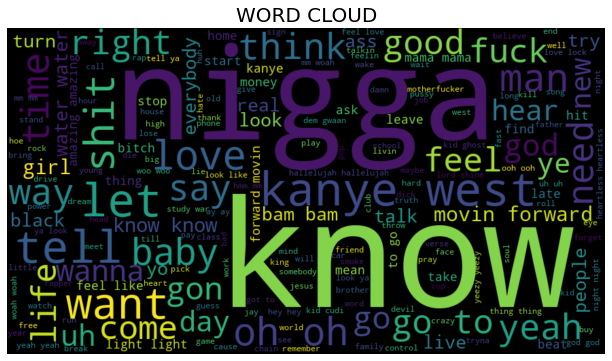

In [175]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = " ".join(lyrics)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=880, height=480, margin=0,).generate(text)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")
plt.title('WORD CLOUD', fontsize = 20)
plt.margins(x=0, y=0)
plt.show()

In [118]:
from collections import Counter
from nltk import ngrams
count = Counter()
for lyric in tqdm.tqdm(dg_songs_base["lyrics"].values):
    thing = ngrams(lyric,1)
    try:
        result = Counter(thing)
    except:
        print(thing)
    #for item, count in sorted(result.items()):
    #    if count>=10:
    #        print(item,count)
result.most_common(10)

100%|██████████| 133/133 [00:00<00:00, 6794.42it/s]


[(('like',), 49),
 (('know',), 32),
 (('beat',), 23),
 (('go',), 20),
 (('man',), 19),
 (('play',), 18),
 (('get',), 17),
 (('Jay',), 16),
 (('shit',), 16),
 (('tell',), 14)]

### 4) Escribir un informe

Este informe tiene que describir qué datos que obtuvieron, el volumen de estos (# de canciones del artista, # de canciones de la competencia, etc), una explicación de cómo estos se relacionan con la pregunta planteada, cómo ayudan a responderla y los resultados que obtuvieron. Usar la celda de abajo con formato markdown.


